In [27]:
# %% libraries

import pandas as pd
from numpy import abs
import numpy as np
import matplotlib.pyplot as plt

from scipy import fft
from sklearn.metrics import r2_score

import datetime as dt
import os,sys

_FILE_DIR = os.path.abspath("")
_MODEL_DIR = os.path.dirname(_FILE_DIR)
_SRC_DIR = os.path.dirname(_MODEL_DIR)
sys.path.append(_MODEL_DIR)
sys.path.append(_SRC_DIR)

# local imports
import tsFB.data.prototyping_metrics as pm
import tsFB.utils.time_chunking as tc
import tsFB.data.build_filterbanks as fb

# optional
import warnings
warnings.filterwarnings("ignore")

# Prepare test data

In [28]:
# %% Get data

year = '2019'
month = '05'
test_cdf_file_path =_MODEL_DIR+fb._OMNI_MAG_DATA_DIR+ year +'/omni_hro_1min_'+ year+month+'01_v01.cdf'

mag_df = fb.get_test_data(fname_full_path=test_cdf_file_path)
cols = ['BY_GSE']
mag_df=mag_df[cols]
mag_df
# mag_df = mag_df-mag_df.mean()  # Include this for fair comparison of DC and/or HF true or false (if both are true, original signal can be reconstructed regardless)

,BY_GSE
2019-05-15 00:00:00,474.4
2019-05-15 00:01:00,475.3
2019-05-15 00:02:00,473.6
2019-05-15 00:03:00,472.6
2019-05-15 00:04:00,470.5
...,...
2019-05-15 23:56:00,419.9
2019-05-15 23:57:00,417.7
2019-05-15 23:58:00,413.2
2019-05-15 23:59:00,411.5


In [29]:
# %% Prepare FT of test data for Fourier applications

cadence = dt.timedelta(seconds=60)

mag_df.sort_index(inplace=True)
mag_df.interpolate(method='index', kind='linear',limit_direction='both',inplace=True)

# Summary of theoretical formulas


## General moving average filter
**(Formula from [Ch. 15 of *Digital Signal Processing Textbook*](https://www.dspguide.com/CH15.PDF))**

Frequency response of an $M$ point moving average filter.
The frequency, $f$, runs between $0$ and $0.5$. For $f = 0$, use $H[f] = 1$

$$H[f] = \frac{\sin(\pi f M)}{M\sin(\pi f)}$$

## Detrending ($DT$)
Frequency response of detrending with window $W_d$,

\begin{align*}

\widetilde{DT}[f] &= 1 - H_d[f] \\

&= 1 - \frac{\sin (\pi f W_d)}{W_d \sin (\pi f)}

\end{align*}

## Smoothing ($SM$)
Frequency response of smoothing with window $W_s$,

\begin{align*}

\widetilde{SM}[f] &= H_s[f] \\

&= \frac{\sin (\pi f W_s)}{W_s \sin (\pi f)}

\end{align*}

## *Both* detrending and smoothing
(just product of the above two)

\begin{align*}

\widetilde{DTSM}[f] &=  \widetilde{DT}[f] \cdot \widetilde{SM}[f] \\

&= (1-H_d[f]) \cdot (H_s[f]) \\

&= \left(1 - \frac{\sin (\pi f W_d)}{W_d \sin (\pi f)}\right) \cdot \left(\frac{\sin (\pi f W_s)}{W_s \sin (\pi f)}\right)

\end{align*}

# Create Frequency Domain Filterbanks

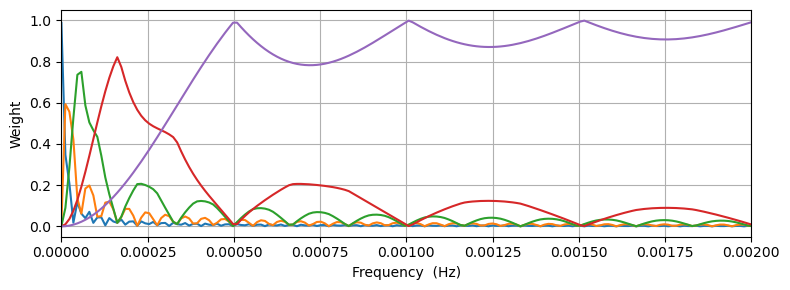

In [30]:
# %% Moving average filterbanks

DTSM = fb.filterbank(data_len=len(mag_df),
                    cadence=dt.timedelta(seconds=60))
DTSM.build_DTSM_fb(windows=[2000,6000,18000,54000])

DTSM.add_mvgavg_DC_HF()
fb.visualize_filterbank(fb_matrix=DTSM.fb_matrix,
                        fftfreq=DTSM.freq_hz_spec,
                        xlim=(0,0.002))

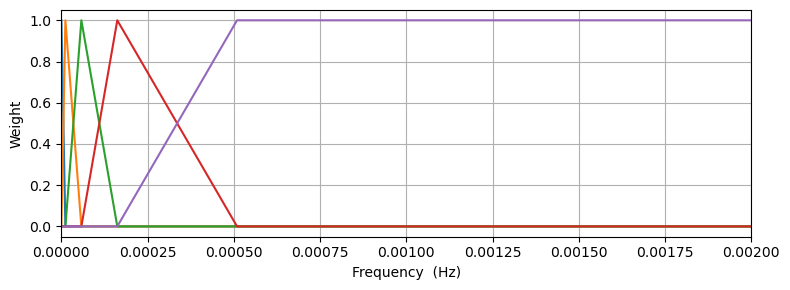

In [31]:
# %% triangle filterbanks

tri = fb.filterbank(data_len=len(mag_df),
                    cadence=dt.timedelta(seconds=60))
tri.build_triangle_fb((0.0,np.sort(DTSM.center_freq)[-1]),
                      center_freq=np.sort(DTSM.center_freq[1:-1]))
tri.add_DC_HF_filters()
fb.visualize_filterbank(fb_matrix=tri.fb_matrix,
                        fftfreq=tri.freq_hz_spec,
                        xlim=(0.0,0.002))

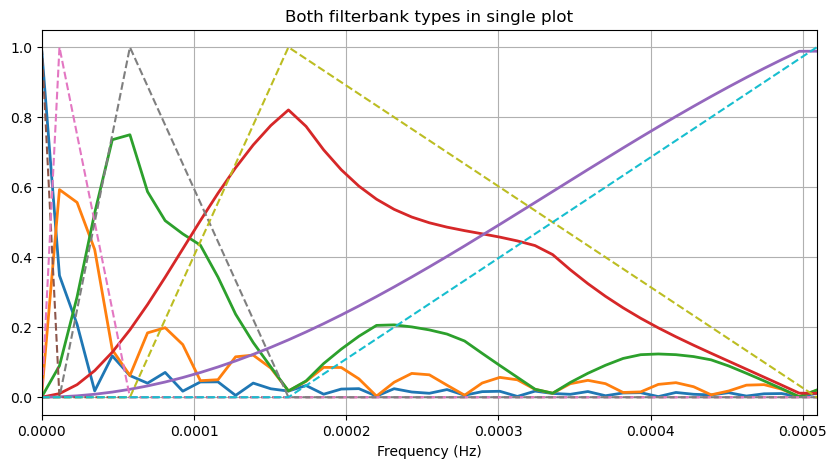

In [32]:
# %% plot all in single plot

plt.figure(figsize=(10,5))
for m_bank in DTSM.fb_matrix:
    plt.plot(DTSM.freq_hz_spec,m_bank,linewidth=2)
for t_bank in tri.fb_matrix:
    plt.plot(tri.freq_hz_spec,t_bank,linestyle='dashed')

plt.xlim(0.0,tri.center_freq[-1])
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.title('Both filterbank types in single plot')
plt.show()

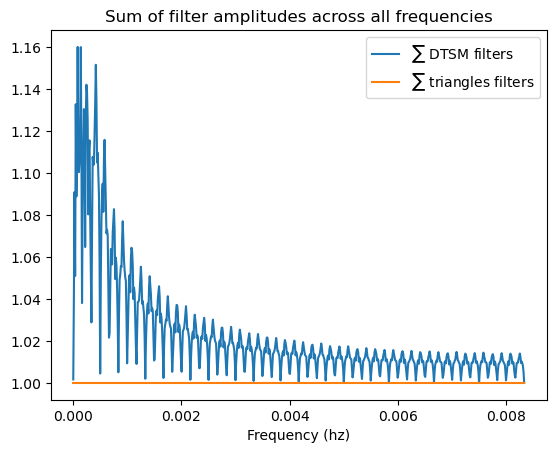

In [33]:
# %% Sum of filterbank amplitudes

plt.plot(DTSM.freq_hz_spec,np.sum(abs(DTSM.fb_matrix),axis=0),label='$\sum$ DTSM filters')
plt.plot(tri.freq_hz_spec,np.sum(tri.fb_matrix,axis=0),label='$\sum$ triangles filters')
plt.xlabel('Frequency (hz)')
plt.title('Sum of filter amplitudes across all frequencies')
plt.legend()
plt.show()

# Apply filterbanks to get a collection of deconstructed signals

In [34]:
# %%

# TODO: Remove PAA application parts for filterbank paper purposes

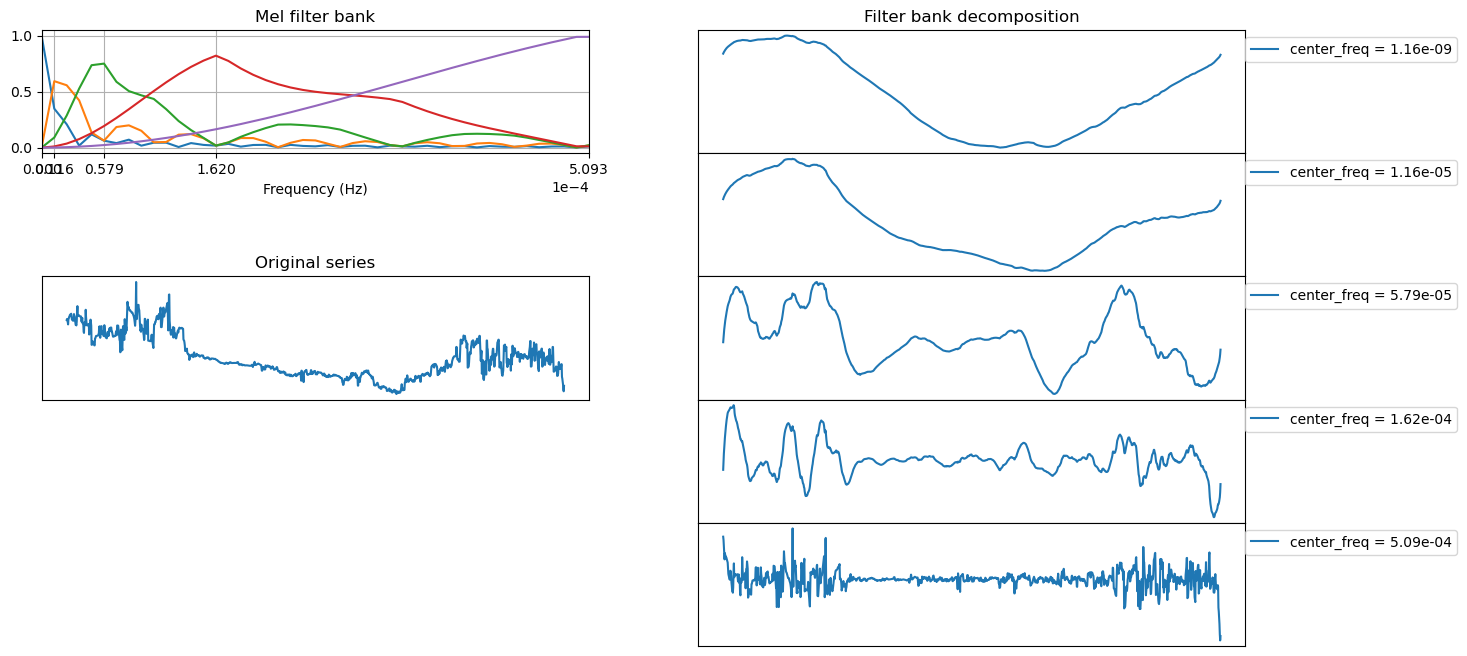

In [35]:
# %%

DTSM_filtered, DTSM_paa = fb.visualize_filterbank_application(data_df=mag_df,
                                                            fb_matrix=DTSM.fb_matrix,
                                                            fftfreq=DTSM.freq_hz_spec,
                                                            data_col='BY_GSE',
                                                            cadence=dt.timedelta(minutes=1),
                                                            wordsize_factor = 3,
                                                            xlim = (0,DTSM.center_freq[-1]),
                                                            center_freq = DTSM.center_freq,
                                                            DC=DTSM.DC,
                                                            HF=DTSM.HF,
                                                            save_results=True)

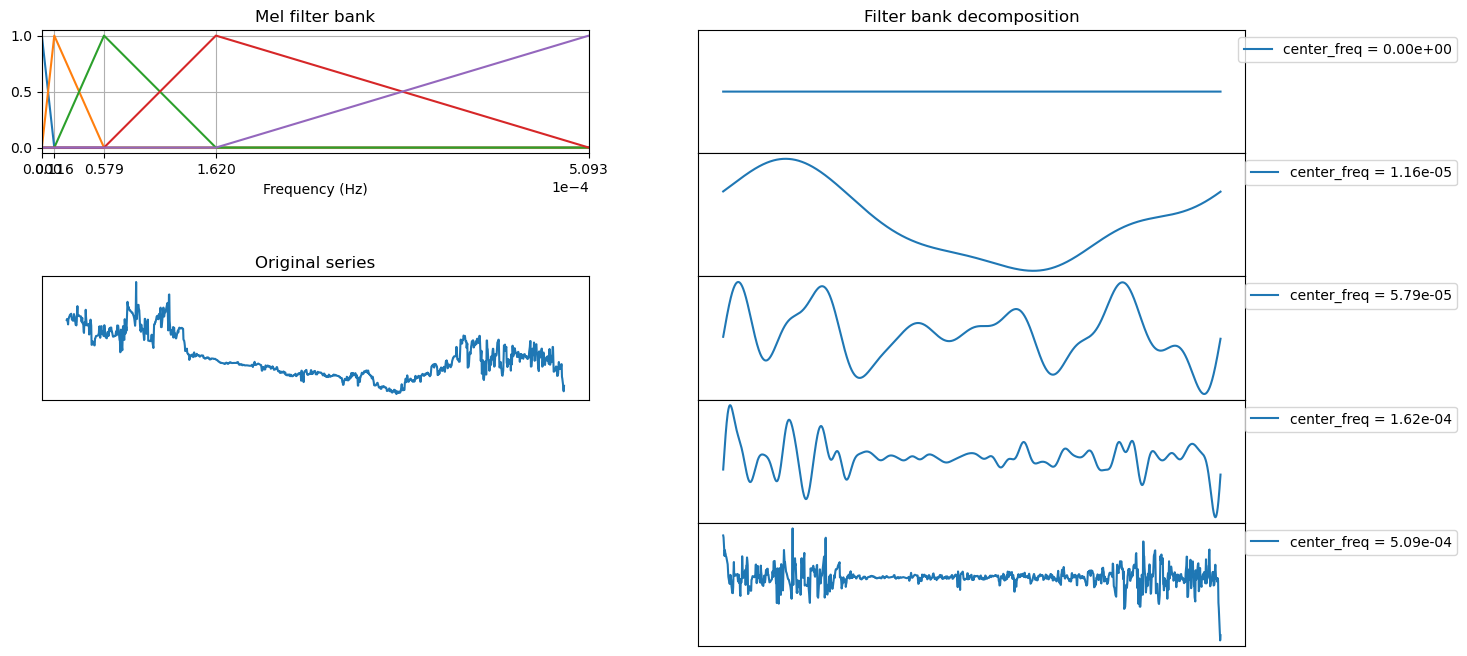

In [36]:
# %%

tri_filtered, tri_paa = fb.visualize_filterbank_application(data_df=mag_df,
                                                            fb_matrix=tri.fb_matrix,
                                                            fftfreq=tri.freq_hz_spec,
                                                            data_col='BY_GSE',
                                                            cadence=dt.timedelta(minutes=1),
                                                            wordsize_factor = 3,
                                                            xlim = (0,tri.center_freq[-1]),
                                                            center_freq = tri.center_freq,
                                                            DC=tri.DC,
                                                            HF=tri.HF,
                                                            save_results=True)

## "bank" of filtered signals from applying smoothing & detrending in time domain
Manually create collection of filtered signals from doing convolution in time domain with the same windows.

In [37]:
# %% "filterbank" of Smoothing & detrending via convolution

convolution_filtered = np.zeros(DTSM_filtered.shape)
DTSM.windows.sort(reverse=True)
for i,w in enumerate(DTSM.windows[:-1]):
    filtered = tc.preprocess_smooth_detrend(mag_df=mag_df,
                                            cols=cols,
                                            detrend_window=dt.timedelta(seconds=w),
                                            smooth_window=dt.timedelta(seconds=DTSM.windows[i+1]))
    convolution_filtered[i+1] = np.array(filtered[cols]).ravel()
# DC
if DTSM.DC:
    DC_filtered = tc.preprocess_smooth_detrend(mag_df=mag_df,
                                            cols=cols,
                                            detrend_window=dt.timedelta(seconds=0),
                                            smooth_window=dt.timedelta(seconds=max(DTSM.windows)))
    convolution_filtered[0] = np.array(DC_filtered).ravel()
# HF
if DTSM.HF:
    HF_filtered = tc.preprocess_smooth_detrend(mag_df=mag_df,
                                            cols=cols,
                                            detrend_window=dt.timedelta(seconds=min(DTSM.windows)),
                                            smooth_window=dt.timedelta(seconds=0))
    convolution_filtered[-1] = np.array(HF_filtered).ravel()

# Compare reconstructed signals (by summing all filtered signals)
 Sum up all of the filtered signals that came out of each filterbank, and compare how they did

In [38]:
# %% save sum of signals

sum_DTSM_filtered = np.sum(DTSM_filtered,axis=0)
sum_tri_filtered = np.sum(tri_filtered,axis=0)
sum_conv_filtered = np.sum(convolution_filtered,axis=0)

## Compare signals directly

In [39]:
# %% calculate r-squared scores

# TODO: these scores may not be that useful, so can probably get rid of them
real = np.array(mag_df).ravel()
DTSM_r2 = r2_score(real,sum_DTSM_filtered)
tri_r2 = r2_score(real,sum_tri_filtered)
conv_r2 = r2_score(real,sum_conv_filtered)

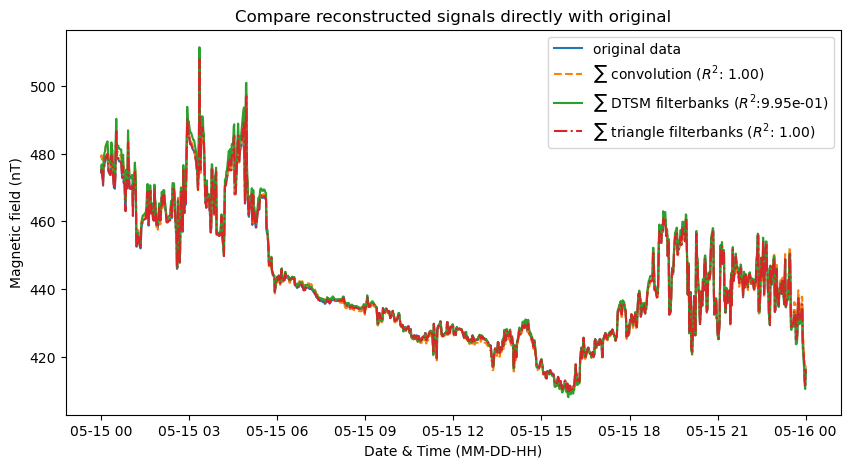

In [40]:
# %% Plot Original vs. Convolution vs. Triangles

plt.figure(figsize=(10,5))
plt.plot(mag_df.index,real,label='original data')
plt.plot(mag_df.index,sum_conv_filtered,linestyle='dashed',label=f'$\sum$ convolution ($R^2$: {conv_r2:.2f})')
plt.plot(mag_df.index,sum_DTSM_filtered,label=f'$\sum$ DTSM filterbanks ($R^2$:{DTSM_r2:.2e})')
plt.plot(mag_df.index,sum_tri_filtered,linestyle='dashdot',label=f'$\sum$ triangle filterbanks ($R^2$: {tri_r2:.2f})')
plt.title('Compare reconstructed signals directly with original')
plt.xlabel('Date & Time (MM-DD-HH)')
plt.ylabel('Magnetic field (nT)')
plt.legend()
plt.show()

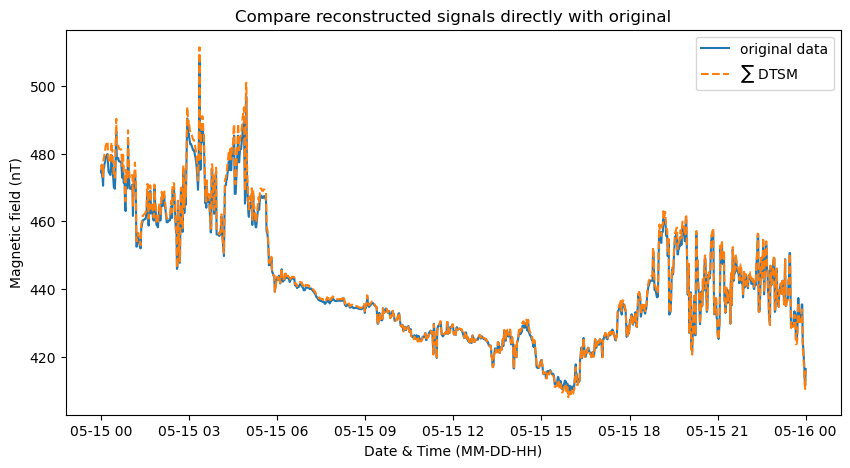

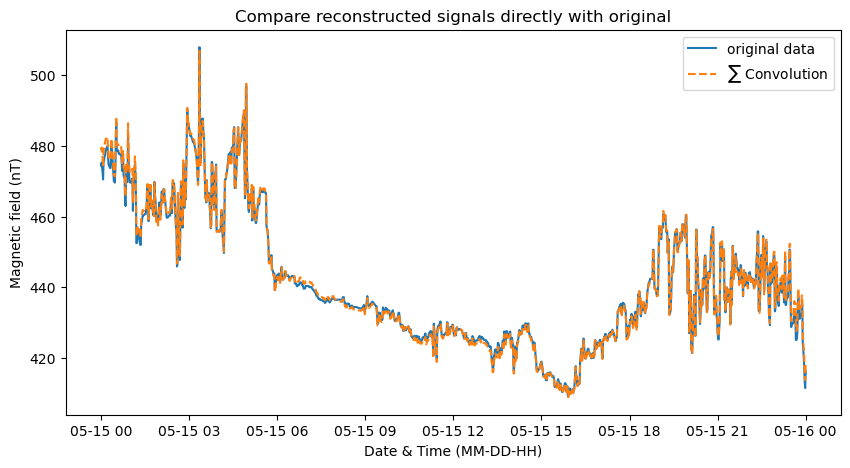

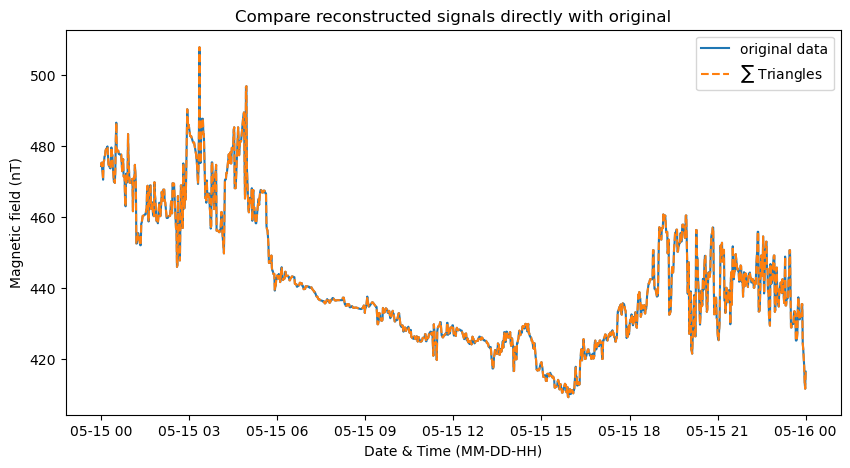

In [41]:
# %% Plot Original vs. Convolution vs. Triangles

sums = {'DTSM':sum_DTSM_filtered,
        'Convolution': sum_conv_filtered,
        'Triangles':sum_tri_filtered}
for i,selection in enumerate(['DTSM','Convolution','Triangles']):
    plt.figure(figsize=(10,5))
    plt.plot(mag_df.index,real,label='original data')
    plt.plot(mag_df.index,sums[selection],linestyle='dashed',label=f'$\sum$ {selection}')
    plt.title('Compare reconstructed signals directly with original')
    plt.xlabel('Date & Time (MM-DD-HH)')
    plt.ylabel('Magnetic field (nT)')
    plt.legend()
    plt.show()

In [42]:
# %% residuals

DTSM_residual = real-sum_DTSM_filtered
tri_residual = real-sum_tri_filtered
conv_residual = real - sum_conv_filtered

residuals = {'DTSM':DTSM_residual,
            'Triangles':tri_residual,
            'Convolution':conv_residual}

## Residuals of reconstructed signals compared with original

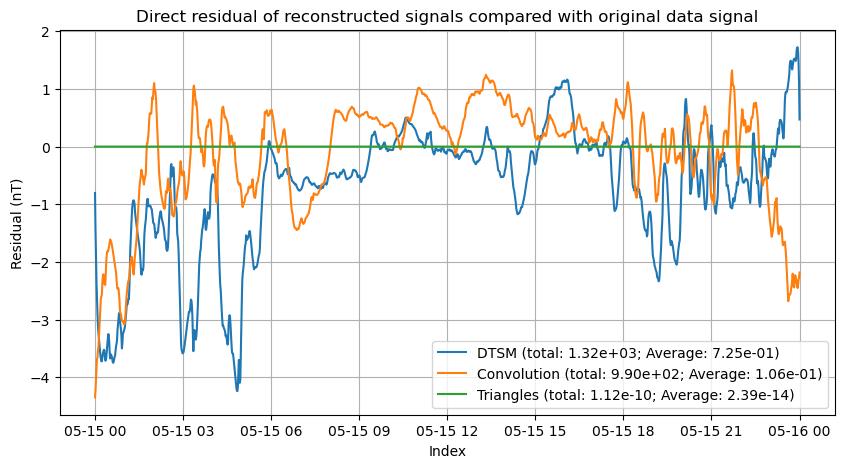

In [43]:
# %% Plot residuals: all in single plot

plt.figure(figsize=(10,5))
for i,selection in enumerate(['DTSM','Convolution','Triangles']):
    plt.plot(mag_df.index,residuals[selection],
             label=f'{selection} (total: {sum(abs(residuals[selection])):.2e}; Average: {abs(residuals[selection].mean()):.2e})')
    plt.legend()
plt.xlabel('Index')
plt.ylabel('Residual (nT)')
plt.title('Direct residual of reconstructed signals compared with original data signal')
plt.grid()
plt.show()

In [44]:
# %% relative residuals

# DTSM_rel_residual = np.abs(DTSM_residual)/np.abs(real)
# tri_rel_residual = np.abs(tri_residual)/np.abs(real)
# conv_rel_residual = np.abs(conv_residual)/np.abs(real)

DTSM_rel_residual = DTSM_residual/real
tri_rel_residual = tri_residual/real
conv_rel_residual = conv_residual/real

rel_residuals = {'DTSM':DTSM_rel_residual,
            'Triangles':tri_rel_residual,
            'Convolution':conv_rel_residual}

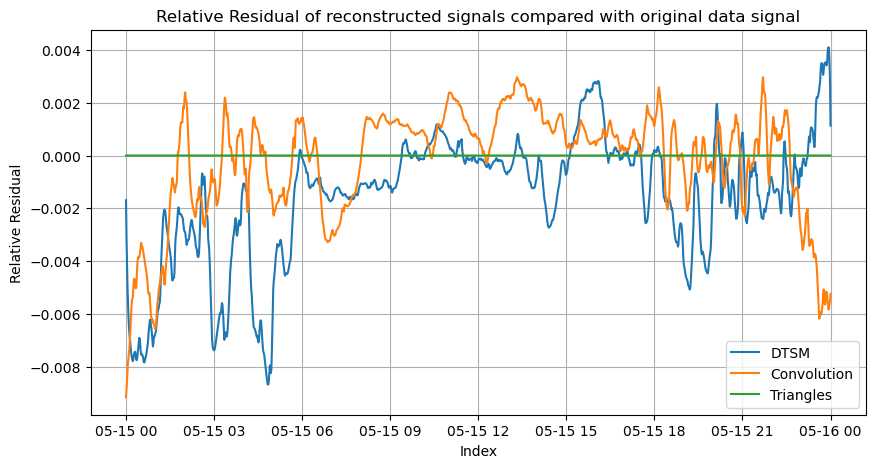

In [45]:
# %% Plot relative residuals

plt.figure(figsize=(10,5))
for i,selection in enumerate(['DTSM','Convolution','Triangles']):
    plt.plot(mag_df.index,rel_residuals[selection],
             label=f'{selection}')
    plt.legend()
plt.xlabel('Index')
plt.ylabel('Relative Residual')
plt.title('Relative Residual of reconstructed signals compared with original data signal')
plt.grid()
plt.show()

In [46]:
# %% Plot relative residuals: individually

# for i,selection in enumerate(['DTSM','Convolution','Triangles']):
#     plt.figure(figsize=(10,5))
#     plt.plot(mag_df.index,rel_residuals[selection],
#              label=f'{selection}')
#     plt.hlines(0.0,min(mag_df.index),max(mag_df.index),
#                colors='black',linewidth=3)
#     plt.legend()
#     plt.xlabel('Index')
#     plt.ylabel('Relative Residual')
#     plt.title('RELATIVE Residual of reconstructed signal compared with original data signal')
#     plt.grid()
#     plt.show()